## Importing necessary modules

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import time
from tqdm import tqdm # Cool progress bar

import random
import numpy as np
import pandas as pd
import sys
import os # read and manipulate local files

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import cv2
import seaborn as sns

from PIL import Image

import tensorflow.keras as ks
import tensorflow as tf

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K # F1-score metric

from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import   Lambda, Conv2D, MaxPool2D, UpSampling2D, BatchNormalization, Flatten
from tensorflow.keras.layers import  GlobalAveragePooling2D, Reshape, Multiply, Attention, add,Resizing,  Input, Dense
from tensorflow.keras.layers import Activation,AveragePooling2D, MaxPooling2D, Dropout, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model, Sequential

# hide wornings
import warnings
warnings.filterwarnings('ignore')

# from keras import ops# For deeplab3

# import keras_cv # basnet

from imgaug import augmenters as iaa ## for augmentation

In [ ]:
!pip install tensorflow-addons
!pip install validators

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 701.1 kB/s eta 0:00:00


## Defining paths

In [ ]:
################################################################################################
## SETTING THE PATHS
PATH_TO_CODE ='/content/drive/MyDrive/TRIAL_v1/segmentation_task'
# PATH_TO_CODE =''
sys.path.append(PATH_TO_CODE)

# DATASET_PATH = r'C:\Users\ASUS\Desktop\segmentation & cropping\segmentation_task\segmentation_data43_resized_cropped_split'
DATASET_PATH = r'/content/drive/MyDrive/TRIAL_v1/segmentation_task/segmentation_data43_resized_cropped_split'
# DATASET_PATH = r'segmentation_data43_resized_cropped_split'
# DATASET_PATH_TRAIN = os.path.join(DATASET_PATH, 'train')
DATASET_PATH_TEST = os.path.join(DATASET_PATH, 'test')


PATH_TO_SAVE_RESULT = os.path.join(PATH_TO_CODE, 'saved_outputs_segmentation','RESULT_PLOTS')
##############################################################################################

if not os.path.exists(PATH_TO_SAVE_RESULT):
 # If it does not exist, create it
    os.makedirs(PATH_TO_SAVE_RESULT)
################################################################################################
IMG_HEIGHT = 256
IMG_WIDTH = 256
ORIGINAL_IMAGE_SIZE = (IMG_HEIGHT, IMG_WIDTH)
COLOR_CHANNEL = 3

RESIZE_SHAPE = ORIGINAL_IMAGE_SIZE #(128, 128) #ORIGINAL_IMAGE_SIZE#(128, 128)# # #ORIGINAL_IMAGE_SIZE# (128, 128)#
MODEL_INPUT_SIZE = (RESIZE_SHAPE[0], RESIZE_SHAPE[1], COLOR_CHANNEL)

VALIDATION_SPLIT= 0.2
NUM_CLASSES = 2 # Disease and not disease

BATCH_SIZE = 15 # originally was 20
EPOCHS = 60

TOTAL_DATA = 2500
################################################################################################

################################################################################################

SAVE_RESULTS = True
SHOW_RESULTS = True

################################################################################################
# Setting the seed
SEED  = 1234
RNG = np.random.default_rng(SEED) # Random number generator
tf.random.set_seed(SEED)

################################################################################################
# Checkpoint parameters val_binary_io_u
SCORE_TO_MONITOR = 'val_binary_io_u' # Score that checkpoints monitor during training
SCORE_OBJECTIVE  = 'max'          # 'max' or 'min', specifies whether the objective is to maximize the score or minimize it.
PATIENCE_LR_REDUCE = 3
MIN_LR = 1e-8
REDUCTION_FACTOR = 0.5            # Factor which lr will be reduced with at plateau
# COOLDOWN_EPOCHS  = 2 #cooldown: Integer. Number of epochs to wait before resuming normal operation after the learning rate has been reduced.

INITIAL_LR = 0.001

## Defining performance metrics

Official segmentation metrics by keras: https://ks.io/api/metrics/segmentation_metrics/

In [ ]:
def f1_score(y_true, y_pred): # Dice coefficient
    """
    Calculate the F1 score, the harmonic mean of precision and recall, for binary classification.

    Args:
        y_true (Tensor): True binary labels.
        y_pred (Tensor): Predicted probabilities.

    Returns:
        float32: F1 score as a scalar.
    """
    # True Positives: round product of y_true and y_pred
    TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    # Actual Positives: round y_true
    P = K.sum(K.round(K.clip(y_true, 0, 1)))
    # Recall: TP / Actual Positives
    recall = TP / (P + K.epsilon())

    # Predicted Positives: round y_pred
    Pred_P = K.sum(K.round(K.clip(y_pred, 0, 1)))
    # Precision: TP / Predicted Positives
    precision = TP / (Pred_P + K.epsilon())

    # F1 Score: harmonic mean of precision and recall
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

# source: https://www.tensorflow.org/api_docs/python/tf/keras/metrics/BinaryIoU
iou_score_binary = tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1], threshold=0.5)

def accuracy_score(y_true, y_pred):
    """
    Calculate accuracy score between two binary masks.
    """
    correct = np.sum(y_true == y_pred)  # Count correct predictions
    total = y_true.size  # Total number of pixels
    return correct / total  # Accuracy calculation

def precision_score(groundtruth_mask, pred_mask):
    """
    Calculate precision score between two binary masks.
    """
    intersect = np.sum(pred_mask * groundtruth_mask)  # Calculate intersection
    total_pixel_pred = np.sum(pred_mask)  # Sum of predicted positives
    return np.mean(intersect / total_pixel_pred)  # Precision calculation

def recall_score(groundtruth_mask, pred_mask):
    """
    Calculate recall score between two binary masks.
    """
    intersect = np.sum(pred_mask * groundtruth_mask)  # Calculate intersection
    total_pixel_truth = np.sum(groundtruth_mask)  # Sum of actual positives
    return np.mean(intersect / total_pixel_truth)  # Recall calculation

## Reading the data

In [ ]:
# Function to read images from a directory using Pillow
def read_images_from_directory(directory_path):
    images = []
    for filename in sorted(os.listdir(directory_path)):
        # filename= filename.lower()

        if filename.endswith(('.png', '.jpg', '.JPG' )):  # Check for image file extensions
            img_path = os.path.join(directory_path, filename)
            img = Image.open(img_path)
            img_array = np.array(img)  # Convert the image to a numpy array if needed
            if img_array is not None:
                images.append(img_array)
    return images

# # Paths to masks and original images within the dataset
# masks_path_train = os.path.join(DATASET_PATH_TRAIN, 'data43_masks_binarised')
# originals_path_train = os.path.join(DATASET_PATH_TRAIN, 'data43_original')

# # Read images into variables
# x_train = read_images_from_directory(originals_path_train)  # Original images
# y_train = read_images_from_directory(masks_path_train)  # Masks

# Paths to masks and original images within the test dataset
masks_path_test = os.path.join(DATASET_PATH_TEST, 'data43_masks_binarised')
originals_path_test = os.path.join(DATASET_PATH_TEST, 'data43_original')

# Read images into variables
x_test = read_images_from_directory(originals_path_test)  # Original images
y_test = read_images_from_directory(masks_path_test)  # Masks

# # Now x_train contains original images, and y_train contains mask images
# print(f"Loaded {len(x_train)} original images into x_train")
# print(f"Loaded {len(y_train)} mask images into y_train")

# Similarly, for test images
print(f"Loaded {len(x_test)} original images into x_test")
print(f"Loaded {len(y_test)} mask images into y_test")

Loaded 23 original images into x_test
Loaded 23 mask images into y_test


## Preprocessing DO NOT RESIZE THE IMAGE-- IT GIVES FINE LINES IN THE OUTPUT

In [ ]:
# # # Resizing
# x_train = [np.array(Image.fromarray(image).resize(RESIZE_SHAPE)) for image in x_train]
# y_train = [np.array(Image.fromarray(image).resize(RESIZE_SHAPE)) for image in y_train]

# x_test = [np.array(Image.fromarray(image).resize(RESIZE_SHAPE)) for image in x_test]
# y_test = [np.array(Image.fromarray(image).resize(RESIZE_SHAPE)) for image in y_test]

# Convert the list to a NumPy array
# x_train = np.array(x_train)
# y_train = np.array(y_train)

x_test = np.array(x_test)
y_test = np.array(y_test)


# Normalizing input between [0,1]
# x_train = x_train.astype("float32")/ np.max(x_train)
x_test  = x_test.astype("float32")/np.max(x_test)

# y_train = y_train.astype("float32")/ np.max(y_train)
y_test  = y_test.astype("float32")/np.max(y_test)

# # Now x_train contains original images, and y_train contains mask images
# print(f"Loaded {len(x_train)} original images into x_train")
# print(f"Loaded {len(y_train)} mask images into y_train")

# Similarly, for test images
print(f"Loaded {len(x_test)} original images into x_test")
print(f"Loaded {len(y_test)} mask images into y_test")

Loaded 23 original images into x_test
Loaded 23 mask images into y_test


## TransUnet additional elements

In [ ]:
## Install: pip install validators
from transunet import TransUNet

def get_TransUNet(n_filters=16, batchnorm=True):
    """--- COde runs--run it in PC2
       # Source: https://github.com/awsaf49/TransUNet-tf/tree/main
    """
    model = TransUNet(image_size=MODEL_INPUT_SIZE[0],
                      pretrain=True,
                     num_classes=1)

    optimizer = Adam(learning_rate=INITIAL_LR)
    model.compile(loss='binary_crossentropy',
                  metrics=['accuracy', f1_score, iou_score_binary],
                  optimizer=optimizer)

    return model

import tensorflow_addons as tfa

tfk = tf.keras
tfkl = tfk.layers
tfm = tf.math
L2_WEIGHT_DECAY = 1e-4
## Extra custom layer for Reloading the best model
class AddPositionEmbs(tfkl.Layer):
    """Adds (optionally learned) positional embeddings to the inputs."""

    def __init__(self, trainable=True, **kwargs):
        super().__init__(trainable=trainable, **kwargs)
        self.trainable = trainable

    def build(self, input_shape):
        assert (
            len(input_shape) == 3
        ), f"Number of dimensions should be 3, got {len(input_shape)}"
        self.pe = tf.Variable(
            name="pos_embedding",
            initial_value=tf.random_normal_initializer(stddev=0.06)(
                shape=(1, input_shape[1], input_shape[2])
            ),
            dtype="float32",
            trainable=self.trainable,
        )

    def call(self, inputs):
        return inputs + tf.cast(self.pe, dtype=inputs.dtype)

class TransformerBlock(tfkl.Layer):
    """Implements a Transformer block."""

    def __init__(self, *args, n_heads, mlp_dim, dropout, trainable=True, **kwargs):
        super().__init__(*args, trainable=trainable, **kwargs)
        self.n_heads = n_heads
        self.mlp_dim = mlp_dim
        self.dropout = dropout

    def build(self, input_shape):
        self.att = MultiHeadSelfAttention(
            n_heads=self.n_heads,
            name="MultiHeadDotProductAttention_1",
        )
        self.mlpblock = tfk.Sequential(
            [
                tfkl.Dense(
                    self.mlp_dim,
                    activation="linear",
                    name=f"{self.name}/Dense_0"
                ),
                tfkl.Lambda(
                    lambda x: tfk.activations.gelu(x, approximate=False)
                )
                if hasattr(tfk.activations, "gelu")
                else tfkl.Lambda(
                    lambda x: tfa.activations.gelu(x, approximate=False)
                ),
                tfkl.Dropout(self.dropout),
                tfkl.Dense(
                    input_shape[-1], name=f"{self.name}/Dense_1"),
                tfkl.Dropout(self.dropout),
            ],
            name="MlpBlock_3",
        )
        self.layernorm1 = tfkl.LayerNormalization(
            epsilon=1e-6, name="LayerNorm_0"
        )
        self.layernorm2 = tfkl.LayerNormalization(
            epsilon=1e-6, name="LayerNorm_2"
        )
        self.dropout = tfkl.Dropout(self.dropout)

    def call(self, inputs, training):
        x = self.layernorm1(inputs)
        x, weights = self.att(x)
        x = self.dropout(x, training=training)
        x = x + inputs
        y = self.layernorm2(x)
        y = self.mlpblock(y)
        return x + y, weights



class SegmentationHead(tfkl.Layer):
    def __init__(self, name="seg_head",
                 num_classes=9,
                 kernel_size=1,
                 final_act='sigmoid',
                 ** kwargs):
        super(SegmentationHead, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.kernel_size = kernel_size
        self.final_act  = final_act

    def build(self, input_shape):
        self.conv = tfkl.Conv2D(
            filters=self.num_classes, kernel_size=self.kernel_size, padding="same",
            kernel_regularizer=tfk.regularizers.L2(L2_WEIGHT_DECAY),
            kernel_initializer=tfk.initializers.LecunNormal())
        self.act = tfkl.Activation(self.final_act)

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.act(x)
        return x


class Conv2DReLu(tfkl.Layer):
    def __init__(self, filters, kernel_size, padding="same", strides=1, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.padding = padding
        self.strides = strides

    def build(self, input_shape):
        self.conv = tfkl.Conv2D(
            filters=self.filters, kernel_size=self.kernel_size, strides=self.strides,
            padding=self.padding, use_bias=False, kernel_regularizer=tfk.regularizers.L2(L2_WEIGHT_DECAY),
            kernel_initializer="lecun_normal")

        self.bn = tfkl.BatchNormalization(momentum=0.9, epsilon=1e-5)

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = tf.nn.relu(x)
        return x


class DecoderBlock(tfkl.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters

    def build(self, input_shape):
        self.conv1 = Conv2DReLu(filters=self.filters, kernel_size=3)
        self.conv2 = Conv2DReLu(filters=self.filters, kernel_size=3)
        self.upsampling = tfkl.UpSampling2D(
            size=2, interpolation="bilinear")

    def call(self, inputs, skip=None):
        x = self.upsampling(inputs)
        if skip is not None:
            x = tf.concat([x, skip], axis=-1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class DecoderCup(tfkl.Layer):
    def __init__(self, decoder_channels, n_skip=3, **kwargs):
        super().__init__(**kwargs)
        self.decoder_channels = decoder_channels
        self.n_skip = n_skip

    def build(self, input_shape):
        self.conv_more = Conv2DReLu(filters=512, kernel_size=3)
        self.blocks = [DecoderBlock(filters=out_ch)
                       for out_ch in self.decoder_channels]

    def call(self, hidden_states, features):
        x = self.conv_more(hidden_states)
        for i, decoder_block in enumerate(self.blocks):
            if features is not None:
                skip = features[i] if (i < self.n_skip) else None
            else:
                skip = None
            x = decoder_block(x, skip=skip)
        return x

class MultiHeadSelfAttention(tfkl.Layer):
    def __init__(self, *args, trainable=True, n_heads, **kwargs):
        super().__init__(trainable=trainable, *args, **kwargs)
        self.n_heads = n_heads

    def build(self, input_shape):
        hidden_size = input_shape[-1]
        n_heads = self.n_heads
        if hidden_size % n_heads != 0:
            raise ValueError(
                f"embedding dimension = {hidden_size} should be divisible by number of heads = {n_heads}"
            )
        self.hidden_size = hidden_size
        self.projection_dim = hidden_size // n_heads
        self.query_dense = tfkl.Dense(
            hidden_size, name="query")
        self.key_dense = tfkl.Dense(
            hidden_size, name="key")
        self.value_dense = tfkl.Dense(
            hidden_size, name="value")
        self.combine_heads = tfkl.Dense(
            hidden_size, name="out")

    # pylint: disable=no-self-use
    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], score.dtype)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(
            x, (batch_size, -1, self.n_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)

        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.hidden_size))
        output = self.combine_heads(concat_attention)
        return output, weights

## Models
### Models worked
- Model01: Basic basic_unet
- Model02: unet_vgg16 (my own custom)
- Model03: TransUNet
- Model04: DeepLab-v3Plus
- Model05: ResUNet
- Model06: UNet_with_attention
- Model07: Multi-resUnet
- Model08: Inception_resnetV2 (my own custom)



## Loading the best model

In [ ]:
model_path_Basic_Unet='/content/drive/MyDrive/TRIAL_v1/segmentation_task/saved_outputs_segmentation/1500/Basic_Unet__without_drop_1500_without_norm/saved_models/best_Basic_Unet__without_drop_1500_without_norm.h5'
model_path_DeepLabv3Plus_resnet50='/content/drive/MyDrive/TRIAL_v1/segmentation_task/saved_outputs_segmentation/1500/DeepLabv3Plus_1500_RESNET50/saved_models/best_DeepLabv3Plus.h5'
model_path_DeepLabv3Plus_resnet101='/content/drive/MyDrive/TRIAL_v1/segmentation_task/saved_outputs_segmentation/1500/DeepLabv3Plus_1500_RESNET101/saved_models/best_DeepLabv3Plus_1500_RESNET101.h5'
model_path_TransUNet='/content/drive/MyDrive/TRIAL_v1/segmentation_task/saved_outputs_segmentation/1500/TransUNet1500_batch10/saved_models/best_TransUNet1500_batch10.h5'
model_path_Inception_resnetV2_Unet='/content/drive/MyDrive/TRIAL_v1/segmentation_task/saved_outputs_segmentation/1500/Inception_resnetV2_Unet_1500_v2/saved_models/best_Inception_resnetV2_Unet_v2.h5'
model_path_Attention_UNet='/content/drive/MyDrive/TRIAL_v1/segmentation_task/saved_outputs_segmentation/1500/Attention_UNet_1500/saved_models/best_Attention_UNet.h5'
model_path_Multi_resUnet='/content/drive/MyDrive/TRIAL_v1/segmentation_task/saved_outputs_segmentation/1500/Multi_resUnet_1500_v2/saved_models/best_Multi_resUnet_1500_v2.h5'
model_path_Vgg16_unet='/content/drive/MyDrive/TRIAL_v1/segmentation_task/saved_outputs_segmentation/1500/Vgg16_unet1500_v3_TAKE/saved_models/best_Vgg16_unet1500_v3.h5'
model_path_ResUNet='/content/drive/MyDrive/TRIAL_v1/segmentation_task/saved_outputs_segmentation/1500/deep_ResUNet_1500_batch10/saved_models/best_deep_ResUNet_1500_batch10.h5'


In [ ]:
##Now, load the best model
best_model_Basic_Unet = ks.models.load_model(model_path_Basic_Unet,
                                  custom_objects={'f1_score': f1_score,
                                                  'binary_io_u':iou_score_binary})
best_model_DeepLabv3Plus_resnet50 = ks.models.load_model(model_path_DeepLabv3Plus_resnet50,
                                  custom_objects={'f1_score': f1_score,
                                                  'binary_io_u':iou_score_binary})

best_model_DeepLabv3Plus_resnet101 = ks.models.load_model(model_path_DeepLabv3Plus_resnet101,
                                  custom_objects={'f1_score': f1_score,
                                                  'binary_io_u':iou_score_binary})
best_model_TransUnet = ks.models.load_model(model_path_TransUNet,
                                  custom_objects={'f1_score': f1_score,
                                                  'binary_io_u':iou_score_binary,
                                                  'AddPositionEmbs': AddPositionEmbs,
                                                 'TransformerBlock':TransformerBlock,
                                                 'DecoderCup':DecoderCup,
                                                 'SegmentationHead':SegmentationHead,
                                                 'MultiHeadSelfAttention':MultiHeadSelfAttention,
                                                 'Conv2DReLu':Conv2DReLu})

best_model_Inception_resnetV2_Unet = ks.models.load_model(model_path_Inception_resnetV2_Unet,
                                  custom_objects={'f1_score': f1_score,
                                                  'binary_io_u':iou_score_binary})
best_model_Attention_UNet = ks.models.load_model(model_path_Attention_UNet,
                                  custom_objects={'f1_score': f1_score,
                                                  'binary_io_u':iou_score_binary})
best_model_Multi_resUnet = ks.models.load_model(model_path_Multi_resUnet,
                                  custom_objects={'f1_score': f1_score,
                                                  'binary_io_u':iou_score_binary})
best_model_Vgg16_unet = ks.models.load_model(model_path_Vgg16_unet,
                                  custom_objects={'f1_score': f1_score,
                                                  'binary_io_u':iou_score_binary})
best_model_ResUNet = ks.models.load_model(model_path_ResUNet,
                                  custom_objects={'f1_score': f1_score,
                                                  'binary_io_u':iou_score_binary})



## Visualize model predictions

In [ ]:
USER_DETERMINED_THRESHOLD = 0.5

# Get predictions from the model
predictions_basic_unet = best_model_Basic_Unet.predict(x_test, verbose=1)

thresholded_predictions_basic_unet  = (predictions_basic_unet >= USER_DETERMINED_THRESHOLD)
# # Removing the color channel
# thresholded_predictions_without_color_channel_basic_unet = np.squeeze(thresholded_predictions_basic_unet, axis=-1)

###################################################################################################################
# Get predictions from the model
predictions_DeepLabv3Plus_resnet50 = best_model_DeepLabv3Plus_resnet50.predict(x_test, verbose=1)

thresholded_predictions_DeepLabv3Plus_resnet50  = (predictions_DeepLabv3Plus_resnet50 >= USER_DETERMINED_THRESHOLD)
# # Removing the color channel
# thresholded_predictions_without_color_channel_DeepLabv3Plus_resnet50 = np.squeeze(thresholded_predictions_DeepLabv3Plus_resnet50, axis=-1)

###################################################################################################################

###################################################################################################################
# Get predictions from the model
predictions_DeepLabv3Plus_resnet101 = best_model_DeepLabv3Plus_resnet101.predict(x_test, verbose=1)

thresholded_predictions_DeepLabv3Plus_resnet101  = (predictions_DeepLabv3Plus_resnet101 >= USER_DETERMINED_THRESHOLD)
# # Removing the color channel
# thresholded_predictions_without_color_channel_DeepLabv3Plus_resnet101  = np.squeeze(thresholded_predictions_DeepLabv3Plus_resnet101, axis=-1)

###################################################################################################################

# Get predictions from the model
predictions_TransUnet = best_model_TransUnet.predict(x_test, verbose=1)

thresholded_predictions_TransUnet  = (predictions_TransUnet >= USER_DETERMINED_THRESHOLD)
# # Removing the color channel
# thresholded_predictions_without_color_channel_TransUnet = np.squeeze(thresholded_predictions_TransUnet, axis=-1)

###################################################################################################################
# Get predictions from the model
predictions_Inception_resnetV2_Unet = best_model_Inception_resnetV2_Unet.predict(x_test, verbose=1)

thresholded_predictions_Inception_resnetV2_Unet  = (predictions_Inception_resnetV2_Unet >= USER_DETERMINED_THRESHOLD)
# # Removing the color channel
# thresholded_predictions_without_color_channel_Inception_resnetV2_Unet = np.squeeze(thresholded_predictions_Inception_resnetV2_Unet, axis=-1)

###################################################################################################################
# Get predictions from the model
predictions_Attention_UNet = best_model_Attention_UNet.predict(x_test, verbose=1)

thresholded_predictions_Attention_UNet  = (predictions_Attention_UNet >= USER_DETERMINED_THRESHOLD)
# # Removing the color channel
# thresholded_predictions_without_color_channel_Attention_UNet = np.squeeze(thresholded_predictions_Attention_UNet, axis=-1)

###################################################################################################################
# Get predictions from the model
predictions_best_model_Multi_resUnet = best_model_Basic_Unet.predict(x_test, verbose=1)

thresholded_predictions_best_model_Multi_resUnet  = (predictions_best_model_Multi_resUnet >= USER_DETERMINED_THRESHOLD)
# # Removing the color channel
# thresholded_predictions_without_color_channel_best_model_Multi_resUnet = np.squeeze(thresholded_predictions_best_model_Multi_resUnet, axis=-1)

###################################################################################################################
# Get predictions from the model
predictions_Vgg16_unet = best_model_Vgg16_unet.predict(x_test, verbose=1)

thresholded_predictions_Vgg16_unet  = (predictions_Vgg16_unet >= USER_DETERMINED_THRESHOLD)
# # Removing the color channel
# thresholded_predictions_without_color_channel_Vgg16_unet = np.squeeze(thresholded_predictions_Vgg16_unet, axis=-1)

###################################################################################################################
# Get predictions from the model
predictions_ResUNet = best_model_ResUNet.predict(x_test, verbose=1)

thresholded_predictions_ResUNet  = (predictions_ResUNet >= USER_DETERMINED_THRESHOLD)
# # Removing the color channel
# thresholded_predictions_without_color_channel_ResUNet = np.squeeze(thresholded_predictions_ResUNet, axis=-1)

###################################################################################################################

1/1 [==============================] - 8s 8s/step


1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 2s 2s/step


In [ ]:
# plt.figure(figsize=(10, len(x_test) * 2))

# for i in range(len(x_test) ):
#     plt.subplot(len(x_test) , 2, 2*i + 1)
#     plt.imshow(x_test[i])
#     plt.title(f'Original Image - Index {i}')
#     plt.axis('off')

#     plt.subplot(len(x_test) , 2, 2*i + 2)
#     plt.imshow(y_test[i], cmap='gray')
#     plt.title(f'Mask Image - Index {i}')
#     plt.axis('off')

# plt.tight_layout()
# plt.show()

In [ ]:
rand_X_indices =  [0, 16, 20, 10]
rand_X = np.array([x_test[idx] for idx in rand_X_indices])
rand_y = np.array([y_test[idx] for idx in rand_X_indices])


rand_y_predictions_basic_unet = np.array([thresholded_predictions_basic_unet[idx] for idx in rand_X_indices])
rand_y_predictions_DeepLabv3Plus_50= np.array([thresholded_predictions_DeepLabv3Plus_resnet50[idx] for idx in rand_X_indices])
rand_y_predictions_DeepLabv3Plus_101= np.array([thresholded_predictions_DeepLabv3Plus_resnet101[idx] for idx in rand_X_indices])
rand_y_predictions_TransUnet = np.array([thresholded_predictions_TransUnet[idx] for idx in rand_X_indices])
rand_y_predictions_Attention_UNet= np.array([thresholded_predictions_Attention_UNet[idx] for idx in rand_X_indices])
rand_y_predictions_resUnet = np.array([thresholded_predictions_ResUNet[idx] for idx in rand_X_indices])
rand_y_predictions_Multi_resUnet = np.array([thresholded_predictions_best_model_Multi_resUnet[idx] for idx in rand_X_indices])
rand_y_predictions_Vgg16_unet = np.array([thresholded_predictions_Vgg16_unet[idx] for idx in rand_X_indices])
rand_y_predictions_Inception_resnetV2_Unet = np.array([thresholded_predictions_Inception_resnetV2_Unet[idx] for idx in rand_X_indices])

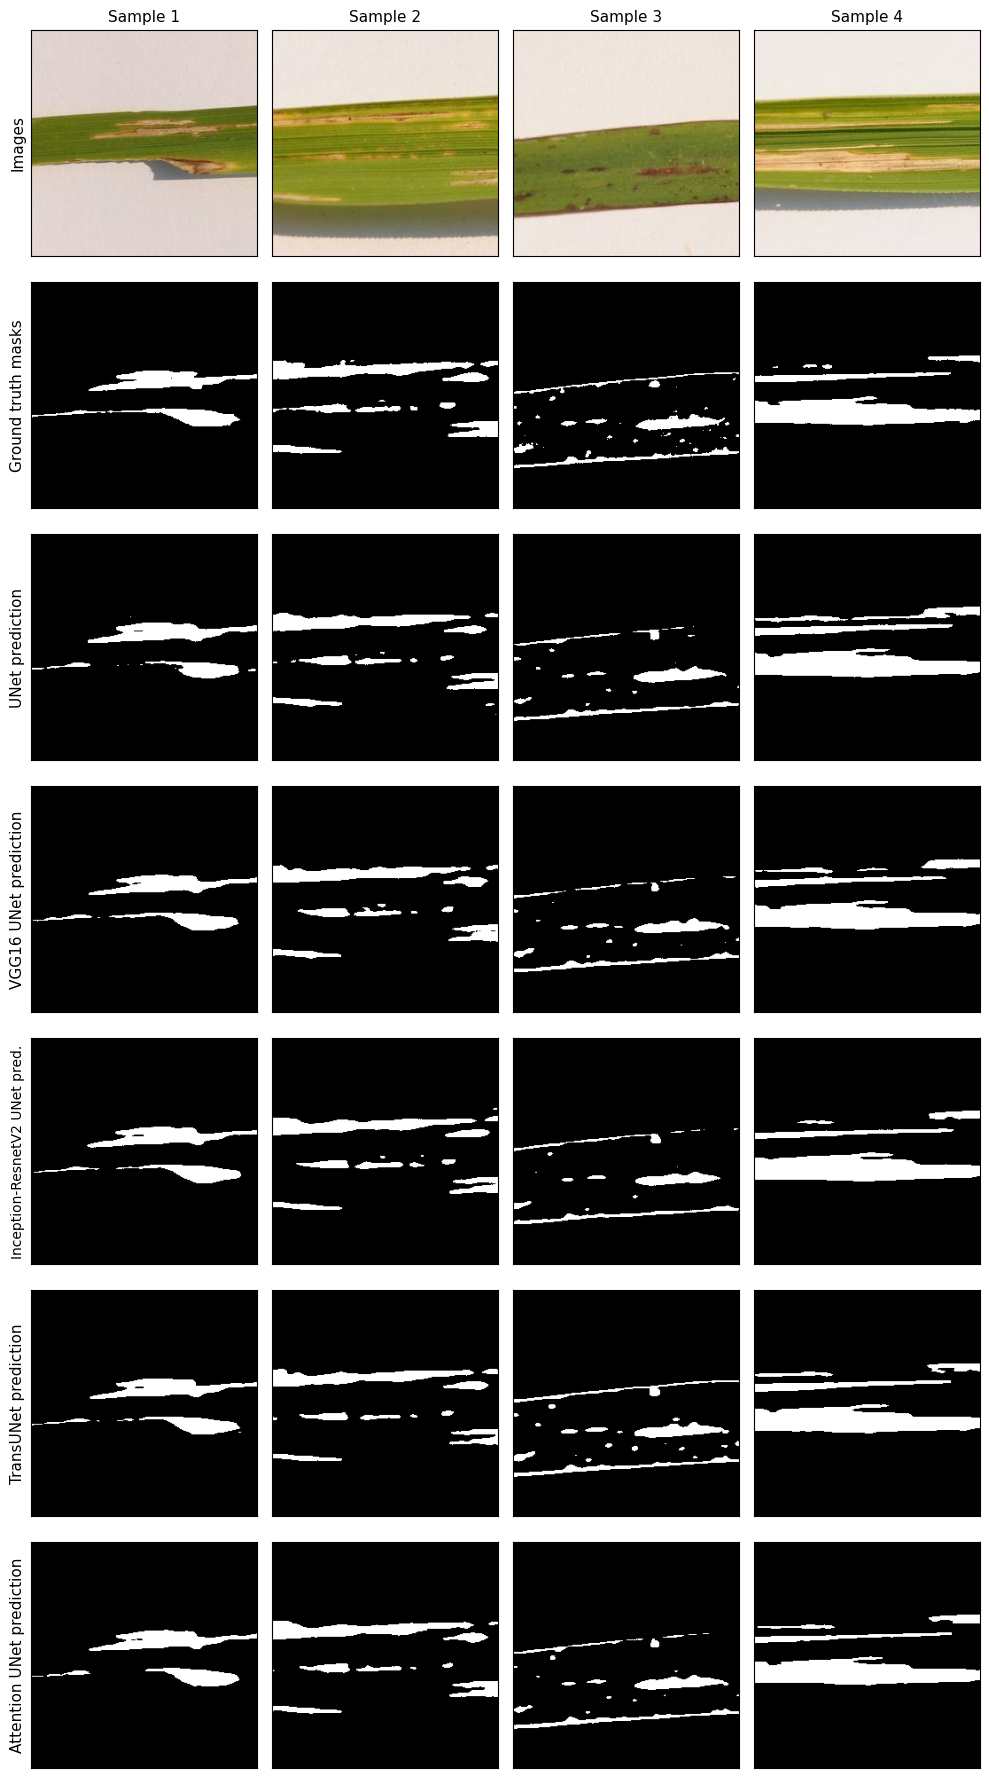

In [ ]:
fig, ax = plt.subplots(7,4, figsize=(10,18))
for i in range(4):
    ax[0,i].imshow(rand_X[i])
    ax[1,i].imshow(rand_y[i], cmap='gray')
    ax[2,i].imshow(rand_y_predictions_basic_unet[i], cmap='gray')

    ax[3,i].imshow(rand_y_predictions_Vgg16_unet[i], cmap='gray')
    ax[4,i].imshow(rand_y_predictions_Inception_resnetV2_Unet[i], cmap='gray')



    ax[5,i].imshow(rand_y_predictions_TransUnet[i], cmap='gray')
    ax[6,i].imshow(rand_y_predictions_Attention_UNet[i], cmap='gray')


ax[0,0].set_title('Sample 1', fontsize=11)
ax[0,1].set_title('Sample 2', fontsize=11)
ax[0,2].set_title('Sample 3', fontsize=11)
ax[0,3].set_title('Sample 4', fontsize=11)

ax[0,0].set_ylabel('Images', fontsize=11)
ax[1,0].set_ylabel('Ground truth masks', fontsize=11)
ax[2,0].set_ylabel('UNet prediction', fontsize=11)
ax[3,0].set_ylabel('VGG16 UNet prediction', fontsize=11)
ax[4,0].set_ylabel('Inception-ResnetV2 UNet pred.', fontsize=10)
ax[5,0].set_ylabel('TransUNet prediction', fontsize=11)
ax[6,0].set_ylabel('Attention UNet prediction', fontsize=11)


for axes in ax.flatten():
    axes.set_xticks([])
    axes.set_yticks([])

fig.tight_layout()


# Save the plot to a PDF
if SAVE_RESULTS:
    pdf_filename = os.path.join(PATH_TO_SAVE_RESULT, "prediction_sample03_1500_part1.pdf")
    with PdfPages(pdf_filename) as pdf:
        pdf.savefig()  # saves the current figure into a pdf page
        # plt.close()
        if SHOW_RESULTS:
            plt.show()
        else:
            plt.close()

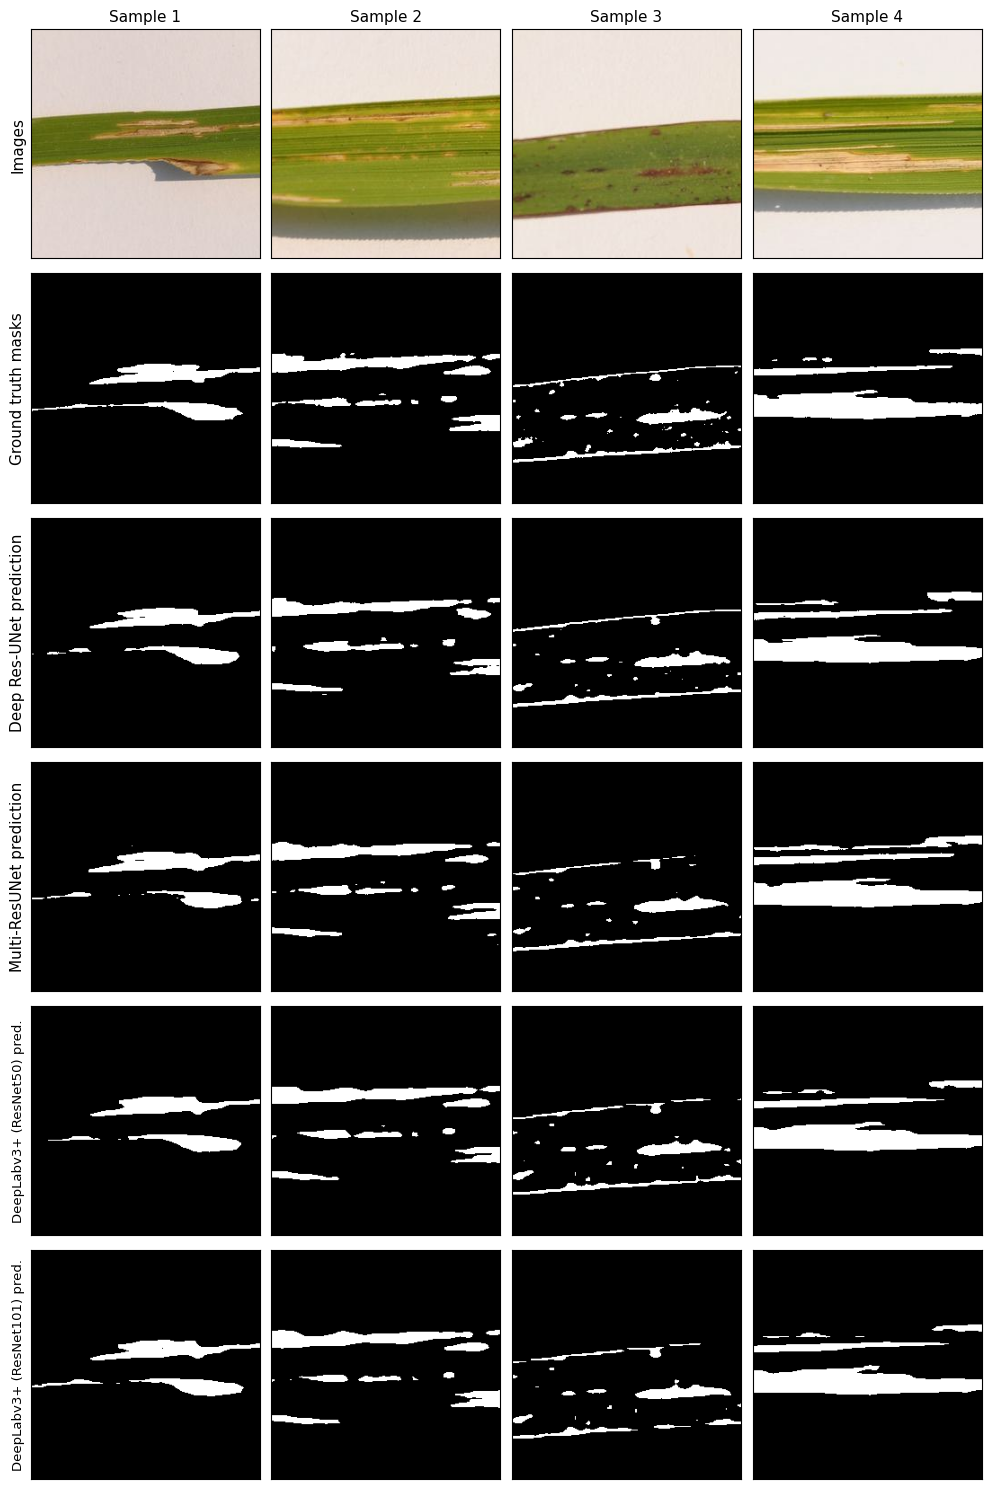

In [ ]:
fig, ax = plt.subplots(6,4, figsize=(10,15))
for i in range(4):
    ax[0,i].imshow(rand_X[i])
    ax[1,i].imshow(rand_y[i], cmap='gray')
    ax[2,i].imshow(rand_y_predictions_resUnet[i], cmap='gray')
    ax[3,i].imshow(rand_y_predictions_Multi_resUnet[i], cmap='gray')
    ax[4,i].imshow(rand_y_predictions_DeepLabv3Plus_50[i], cmap='gray')
    ax[5,i].imshow(rand_y_predictions_DeepLabv3Plus_101[i], cmap='gray')


ax[0,0].set_title('Sample 1', fontsize=11)
ax[0,1].set_title('Sample 2', fontsize=11)
ax[0,2].set_title('Sample 3', fontsize=11)
ax[0,3].set_title('Sample 4', fontsize=11)

ax[0,0].set_ylabel('Images', fontsize=11)
ax[1,0].set_ylabel('Ground truth masks', fontsize=11)
ax[2,0].set_ylabel('Deep Res-UNet prediction', fontsize=11)
ax[3,0].set_ylabel('Multi-ResUNet prediction', fontsize=11)
ax[4,0].set_ylabel('DeepLabv3+ (ResNet50) pred.', fontsize=9.5)
ax[5,0].set_ylabel('DeepLabv3+ (ResNet101) pred.', fontsize=9.5)



for axes in ax.flatten():
    axes.set_xticks([])
    axes.set_yticks([])

fig.tight_layout()


# Save the plot to a PDF
if SAVE_RESULTS:
    pdf_filename = os.path.join(PATH_TO_SAVE_RESULT, "prediction_sample03_1500_part2.pdf")
    with PdfPages(pdf_filename) as pdf:
        pdf.savefig()  # saves the current figure into a pdf page
        # plt.close()
        if SHOW_RESULTS:
            plt.show()
        else:
            plt.close()

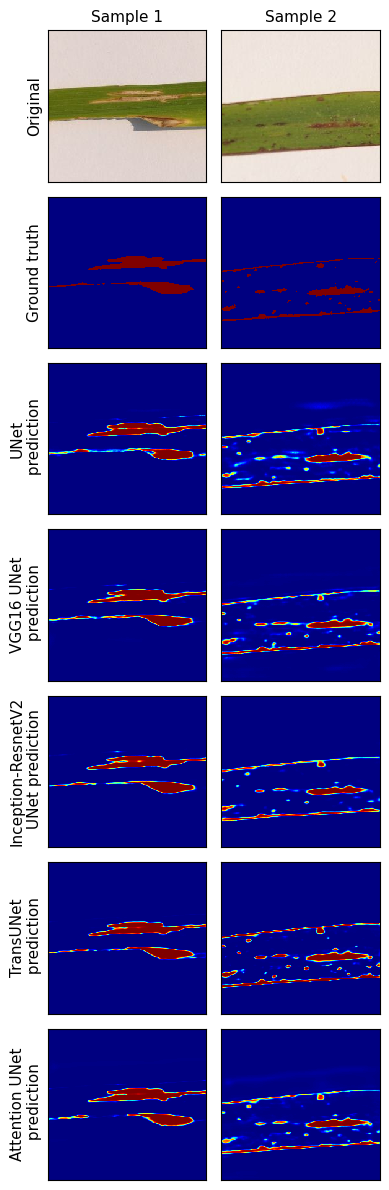

In [ ]:
sample_indices = [0, 20]
num_samples = len(sample_indices)
fig, axes = plt.subplots(7, num_samples, figsize=(4, 12))
# plt.subplots_adjust(0, 0, 1, 1, hspace=0.1, wspace=0.1)
plt.subplots_adjust(hspace=0.3, wspace=0.4)

# Titles for the columns
titles = ['Sample {}'.format(i+1) for i in range(num_samples)]
side_titles = ['Original', 'Ground truth', 'UNet\n prediction', 'VGG16 UNet\n prediction', 'Inception-ResnetV2\n UNet prediction',
               'TransUNet\n prediction', 'Attention UNet\n prediction']  # Side titles for rows

for i, sample_index in enumerate(sample_indices):
    data = [
        x_test[sample_index, ...],
        y_test [sample_index, ...],
        predictions_basic_unet[sample_index, ..., 0],

        predictions_Vgg16_unet [sample_index, ..., 0],
        predictions_Inception_resnetV2_Unet [sample_index, ..., 0],

        predictions_TransUnet[sample_index, ..., 0],
        predictions_Attention_UNet [sample_index, ..., 0],
    ]

    cmaps = [None, plt.cm.jet, plt.cm.jet, plt.cm.jet, plt.cm.jet, plt.cm.jet, plt.cm.jet]

    for j, (datum, cmap) in enumerate(zip(data, cmaps)):
        datum = np.flipud(datum) # flipping the image
        ax = axes[j, i]  # # Select the appropriate subplot
        mesh = ax.pcolormesh(datum, cmap=cmap)
        if i == 0:
            ax.set_ylabel(side_titles[j], fontsize=11)
        if j == 0:
            ax.set_title(titles[i], fontsize=11)

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()

# Save the plot to a PDF
if SAVE_RESULTS:
    pdf_filename = os.path.join(PATH_TO_SAVE_RESULT, "prediction_colors_1500_part1.pdf")
    with PdfPages(pdf_filename) as pdf:
        pdf.savefig()  # saves the current figure into a pdf page
        # plt.close()
        if SHOW_RESULTS:
            plt.show()
        else:
            plt.close()

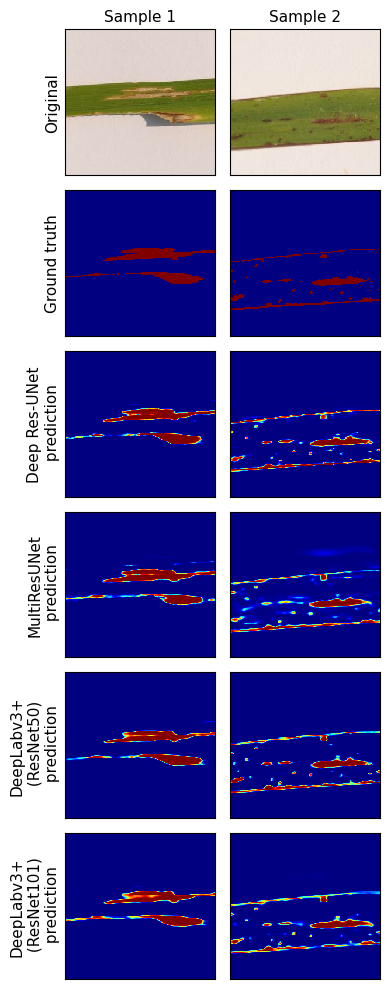

In [ ]:
sample_indices = [0, 20]
num_samples = len(sample_indices)
fig, axes = plt.subplots(6, num_samples, figsize=(4, 10))
plt.subplots_adjust(hspace=0.3, wspace=0.4)

# Titles for the columns
titles = ['Sample {}'.format(i+1) for i in range(num_samples)]
side_titles = ['Original', 'Ground truth', 'Deep Res-UNet\n prediction', 'MultiResUNet\n prediction',
               'DeepLabv3+\n (ResNet50)\n prediction', 'DeepLabv3+\n (ResNet101)\n prediction']  # Side titles for rows

for i, sample_index in enumerate(sample_indices):
    data = [
        x_test[sample_index, ...],
        y_test [sample_index, ...],
        predictions_ResUNet[sample_index, ..., 0],
        predictions_best_model_Multi_resUnet[sample_index, ..., 0],

        predictions_DeepLabv3Plus_resnet50 [sample_index, ..., 0],
        predictions_DeepLabv3Plus_resnet101 [sample_index, ..., 0],


    ]

    cmaps = [None, plt.cm.jet, plt.cm.jet, plt.cm.jet, plt.cm.jet, plt.cm.jet]

    for j, (datum, cmap) in enumerate(zip(data, cmaps)):
        datum = np.flipud(datum) # flipping the image
        ax = axes[j, i]  # # Select the appropriate subplot
        mesh = ax.pcolormesh(datum, cmap=cmap)
        if i == 0:
            ax.set_ylabel(side_titles[j], fontsize=11)
        if j == 0:
            ax.set_title(titles[i], fontsize=11)

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()

# Save the plot to a PDF
if SAVE_RESULTS:
    pdf_filename = os.path.join(PATH_TO_SAVE_RESULT, "prediction_colors_1500_part2.pdf")
    with PdfPages(pdf_filename) as pdf:
        pdf.savefig()  # saves the current figure into a pdf page
        # plt.close()
        if SHOW_RESULTS:
            plt.show()
        else:
            plt.close()